<h1>Problem Set 5</h1> 
<h3><center>Quantitative Macro</center></h3>



<center>Pau Belda-i-Tortosa</center> |


<center>October/November 2018</center>

<h3>Question 2.1: ABHI Model: Partial Equilibrium </h3>


**Recursive Formulation of the Wealth Model**


The recursive formuation of the simple wealth economy is given by, 


(1)  $V_{t}(a,y) = \underset{\bar A \leq a' \leq (1+r) (a+y)}{\max{}} u(wy + (1+r)a - a') + \beta \sum_{y'} \pi(y'|y) V_{t+1}(a',y') $  


where 

(2) $\bar{A} = - \frac{y_{min}}{r}$ 

is the natural borrowing limit. Note that the budget constraint is plugged into the utility function. Taking first order conditions with respect to assets tomororow we get, 

$u'(wy+(1+r)a - a') = \beta \sum_{y'} \pi(y'|y) v_{t+1}'(a',y')$


By the envelope theorem we know that, 

$v_{t}' = u'(c)$

$ v'_{t+1} = u'(c')$


Thus, the stochastic Euler equation is given by, 

(3) $u'(wy+(1+r)a - a') = \beta \sum_{y'} \pi(y'|y) u'(wy' + (1+r)a' - a'')$


**The infinitely-lived households economy**

*Method 1: brute force VFI.*

Notice that we don't need the EE (and then, we don't need to care about slackness conditions). 


Text(0.5,1,'Consumption policy function')

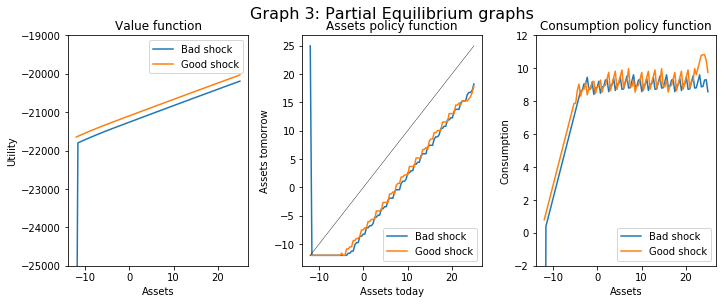

In [3]:
#PARTIAL EQUILIBRIUM

#Import packages
import numpy as np 
from numpy import vectorize
import matplotlib.pyplot as plt
from itertools import product

#Set the parameters
gamma=0.2 #Correlation of y
cbar=50
sigma=0.4  #Standard deviation of y  
r=0.05
beta=1/(1+0.06)
time=100

#STEP 1: Discretize the state space
income = [1-sigma, 1+sigma] #income shocks
a_min= -income[0]/r #natural borrowing limit
assets= np.linspace(a_min, 25, time) #evenly spaced grid
#transition matrix
pi=np.array([((1+gamma)/2,(1-gamma)/2),((1-gamma)/2,(1+gamma)/2)])


#STEP 2: Initial guess
Vs = np.zeros(200)

#STEP 3: Feasible return matrix (M).
#3.1.Grid of all possible combinations of assets (today and tomorrow) and income shocks.  
assets_income_grid = list(product(income,assets,assets))
assets_income_grid =np.array(assets_income_grid)
y=assets_income_grid[:,0]
a_t0=assets_income_grid[:,1]
a_t1=assets_income_grid[:,2]

#3.2. Get the matrix M
@vectorize  
def M(y,ai,aj):
    """Return the utility level associated to all feasible 
    combinations of assets and income shocks. If they are
    not feasible, return a very negative number. 
    """
    if (y + (1+r)*ai - aj)>0: #Feasibility
        return -0.5*pow(((y + (1+r)*ai - aj) - cbar),2)
    else:
        return -100000
    
M = M(y, a_t0, a_t1)
M = np.reshape(M,(1,20000))
M=np.reshape(M,(200,100))

#STEP 4: Compute the matrix W (with an initial guess)
def W1(A):   
    return pi[0, 0]*(-0.5*pow(((income[0] + (1+r)*A - A) - cbar),2))/(1-beta) + pi[0, 1]*(-0.5*(income[1] + (1+r)*A - A - cbar)**2)/(1-beta)

def W2(A):
    
    return pi[1, 0]*(-0.5*(income[0] + (1+r)*A - A - cbar)**2)/(1-beta) + pi[1, 1]*(-0.5*(income[1] + (1+r)*A - A - cbar)**2)/(1-beta)

W1 = W1(assets)
W1 = np.reshape(W1, (100,1))
W1 = np.tile(W1, 100)
W1 = np.transpose(W1)

W2 = W2(assets)
W2 = np.reshape(W2, (100,1))
W2 = np.tile(W2, 100)
W2 = np.transpose(W2)

W = [W1, W2]
W = np.reshape(W, (200,100))

#STEP 5: Compute the matrix X
X = M + beta*W

#STEP 6: Update the value function
Vs1 = np.amax(X, axis = 1)

#STEP 7: 
difference = abs(Vs - Vs1)
count = 0

#If the difference is larger than epsilon, go back to step 4. 
epsilon=1
while difference.all() > epsilon: 
    Vss = Vs1
    Vs = [Vss[0:100], Vss[100:]] #reshape the vector into two columns, one for each shock. 
    Vs = np.array(Vs)
    
    def W1(Vs):
        
        return pi[0, 0]*Vs[0, :] + pi[0, 1]*Vs[1, :]
    
    def W2(Vs):
        
        return pi[1, 0]*Vs[0, :] + pi[1, 1]*Vs[1, :]

    W1 = W1(Vs)
    W1 = np.reshape(W1, (1,100))
    W1 = np.tile(W1, 100)
    W1 = np.transpose(W1)

    W2 = W2(Vs)
    W2 = np.reshape(W2, (1,100))
    W2 = np.tile(W2, 100)
    W2 = np.transpose(W2)
    
    W = [W1, W2]
    W = np.reshape(W, (200, 100))
    
    X = M + beta*W
    
    Vs1 = np.amax(X, axis = 1)
    
    difference = Vss - Vs1
    
    count += 1

#We have converged in 898908 iterations! 

#STEP 8: recover the value function for each shock and the policy function  
#8.1. Value function
V_bad = Vs1[0:100]
V_good = Vs1[100:]

#8.2. Policy function
X = M + beta*W

#8.2.2. Assets policies
g = np.argmax(X, axis = 1)
a_bad = assets[g[0:100]]     
a_good = assets[g[100:]]

#8.2.3. Consumption policies
c_bad = income[0]*np.ones(100) + (1+r)*assets - a_bad

c_good = income[1]*np.ones(100) + (1+r)*assets - a_good

#PLOT EVERYTHING
plt.figure
plt.suptitle("Graph 3: Partial Equilibrium graphs", x=0.75, y=1, fontsize=16)
plt.subplots_adjust(top=0.9, bottom=0.1, left=0, right=1.5, hspace=0.3, wspace=0.3)

plt.subplot(131)
plt.plot(assets,V_bad, label='Bad shock')
plt.plot(assets,V_good, label='Good shock')
plt.xlabel('Assets')
plt.ylabel('Utility')
plt.ylim([-25000, -19000])
plt.legend()
plt.title('Value function')

plt.subplot(132)
plt.plot(assets,a_bad, label='Bad shock')
plt.plot(assets,a_good, label='Good shock')
plt.plot(assets,assets, 'k', linewidth=0.4)
plt.xlabel('Assets today')
plt.ylabel('Assets tomorrow')
#plt.ylim([-23, -6])
plt.legend()
plt.title('Assets policy function')

plt.subplot(133)
plt.plot(assets,c_bad, label='Bad shock')
plt.plot(assets,c_good, label='Good shock')
plt.xlabel('Assets')
plt.ylabel('Consumption')
plt.ylim([-2, 12])
plt.legend()
plt.title('Consumption policy function')

Results:
- All three graphs show the borrowing-constraint phenomenon: eventually, the agent reaches that lower bound and gets a very negative consumption and utility. 

- We can identify a **poverty trap**: the borrowing limit is a fixed point (once you are there, you remain there). Moreover, even if the agent gets a long enough sequence of good shocks, she will end reaching the lower bound. 
(2) even if a long enough sequence of good shocks allow you to start accumulating assets, 

- Consumption is increasing in assets, very rapidly in the very beginning and slowly after that. In other words, **the propensity to consume is much higher for the poors.** 